# NOTEBOOK TO TAKE REBINNED SOPHRONIA AND MERGE WITH GOOD SOPHRONIA TO GET THE ULTIMATE H5 file

- LOAD IN DSTS FROM 15107 NOT REBINNED
- ENFORCE 1 S1 1 S2 AND DT WITHIN RANGE (IN `15107_check.ipynb`)
- APPLY E CORRECTIONS (IN THE NOTEBOOK ONLY) AND SELECT SMALLER HIT DFS FOR LOOKING AT TRACKS (DECONVOLUTION TESTING)
- EXPORT NEW DF WITH NEW RECO AND OLD DST FOR BEERSHEBA RUNNING

Only run beersheba proper once you have analysed the best parameters for beersheba deconvolution for the events of the regions
- DEP (1.6 MeV)
- Low energy X-rays
- Any other peaks (photopeak???)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


In [2]:
run = 15107

In [3]:
# LOAD IN OLD DSTS
OLD_DST = pd.read_hdf('files/DST_15107_passing.h5', key = 'DST/Events')
display(OLD_DST)

# old dst cuts applied
# 0 < DT < 1500
# nS1 = 1, nS2 = 1

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
2,275,1.742935e+09,0,0,1,1,375.0,20.105528,130.680893,1217525.0,...,2539,185.960632,185.960632,18.371055,15.761644,-65.178615,67.057299,-1.333529,190.955556,208.454665
14,590,1.742935e+09,0,0,1,1,400.0,41.841473,240.074432,1139325.0,...,2969,266.157379,266.157379,29.010471,170.053074,19.509000,171.168482,0.114224,217.766683,168.386432
15,597,1.742935e+09,0,0,1,1,650.0,16.592751,97.683167,493475.0,...,2261,919.024780,919.024780,9.251109,75.948209,52.021293,92.056208,0.600559,214.760246,197.605371
20,1556,1.742935e+09,0,0,1,1,350.0,17.792589,102.266724,530275.0,...,2102,877.213196,877.213196,8.832326,110.182593,3.345906,110.233384,0.030358,237.921637,199.830332
25,1794,1.742935e+09,0,0,1,1,275.0,21.349106,106.103920,877900.0,...,2550,531.588501,531.588501,8.046095,108.494903,87.064883,139.109446,0.676251,240.576917,220.669800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25147,658454,1.742944e+09,0,0,1,1,375.0,10.825253,69.822937,1202675.0,...,2851,205.808258,205.808258,9.201199,15.608674,98.721551,99.947863,1.413986,224.630671,251.603989
25152,658699,1.742944e+09,0,0,1,1,575.0,16.538542,87.122505,839450.0,...,2870,567.041748,567.041748,12.670540,40.841408,-8.578211,41.732557,-0.207028,226.215802,217.065314
25153,658923,1.742944e+09,0,0,1,1,625.0,15.709264,91.425804,1274300.0,...,2163,129.195633,129.195633,18.046918,86.402601,-24.296199,89.753634,-0.274119,203.298461,188.980867
25160,1074513,1.742949e+09,0,0,1,1,350.0,19.289764,105.112312,792425.0,...,2470,616.065002,616.065002,13.975123,-3.418172,-1.705237,3.819913,-2.678846,203.424014,201.055704


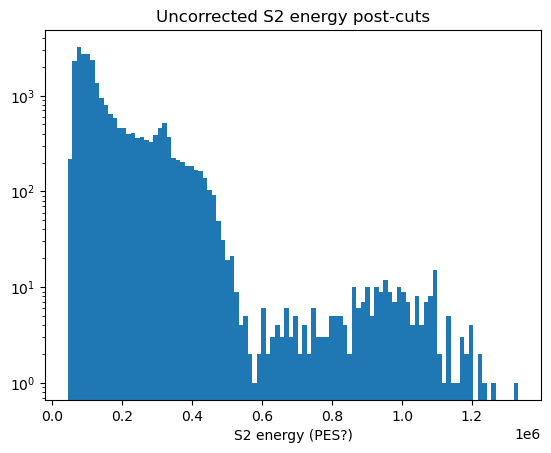

In [6]:
plt.hist(OLD_DST.S2e.values, bins = 100)#, range = [0, 5e5])
plt.title('Uncorrected S2 energy post-cuts')
plt.yscale('log')
plt.xlabel('S2 energy (PES?)')
plt.show()

# Load in rebinned reco data and select only events that are in the above table

In [7]:
events_of_interest = OLD_DST.event.unique()

n100_dir = '/gluster/data/next/files/TOPOLOGY_John/N100_data/15107/sophronia_rebin/trigger_2/'

full_dst = []

for i in tqdm(range(1, 8)):

    print(f"LDC {i}")
    folder_path = n100_dir + 'ldc' + str(i) + '/'
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
    
    dst = load_dsts([folder_path + x for x in file_names], 'RECO', 'Events')
    dst = dst[dst.event.isin(events_of_interest)]
    full_dst.append(dst)

full_dst = pd.concat(full_dst)

  0%|          | 0/7 [00:00<?, ?it/s]

LDC 1


 14%|█▍        | 1/7 [04:00<24:00, 240.01s/it]

LDC 2


 29%|██▊       | 2/7 [06:00<14:07, 169.51s/it]

LDC 3


 43%|████▎     | 3/7 [07:48<09:25, 141.42s/it]

LDC 4


 57%|█████▋    | 4/7 [09:43<06:33, 131.25s/it]

LDC 5


 71%|███████▏  | 5/7 [11:41<04:12, 126.21s/it]

LDC 6


 86%|████████▌ | 6/7 [13:44<02:05, 125.15s/it]

LDC 7


100%|██████████| 7/7 [15:40<00:00, 134.41s/it]


In [8]:
# save the files away
full_dst.to_hdf('files/15107_merger_RECO.h5', key = 'RECO/Events')

# Apply corrections
To the hits it seems?

In [7]:
maps       = read_maps(os.path.expandvars('/gluster/data/next/files/TOPOLOGY_John/LPR/LightTables/map_4bar_15063.h5'))
apply_temp = True
norm_strat = NormStrategy.kr

get_coef  = apply_all_correction( maps
                                , apply_temp = apply_temp
                                , norm_strat = norm_strat
                                , norm_value = None)

time_to_Z = get_df_to_z_converter(maps) if maps.t_evol is not None else identity


In [8]:
# the XYZT values to correct
x_vals = full_dst.X.values
y_vals = full_dst.Y.values
z_vals = full_dst.Z.values
t_vals = full_dst.time.values

In [9]:
get_all_coefs = get_coef(x_vals, y_vals, z_vals, t_vals)


In [10]:
# correct those vals
e_corr = full_dst.E.values * get_all_coefs
full_dst['Ec'] = e_corr

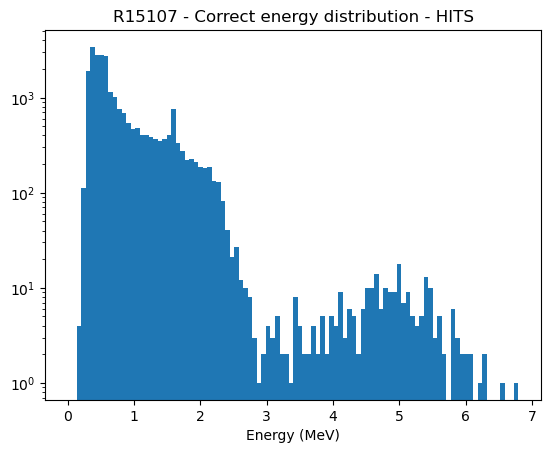

In [19]:
plt.hist(full_dst.groupby('event').Ec.sum(), bins = 100, range = [0, max(full_dst.groupby('event').Ec.sum())])
plt.xlabel('Energy (MeV)')
plt.title(f'R{run} - Correct energy distribution - HITS')
plt.yscale('log')
plt.show()

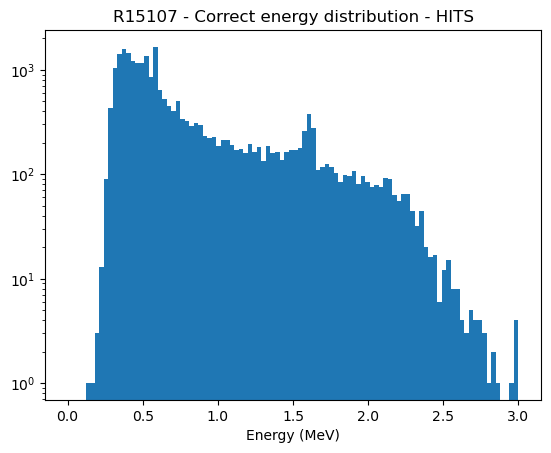

In [18]:
plt.hist(full_dst.groupby('event').Ec.sum(), bins = 100, range = [0, 3])
plt.xlabel('Energy (MeV)')
plt.title(f'R{run} - Correct energy distribution - HITS')
plt.yscale('log')
plt.show()

In [12]:
z_flag = full_dst[full_dst.Z > 1200].event.unique()
low_z_events = full_dst[~full_dst.event.isin(z_flag)]

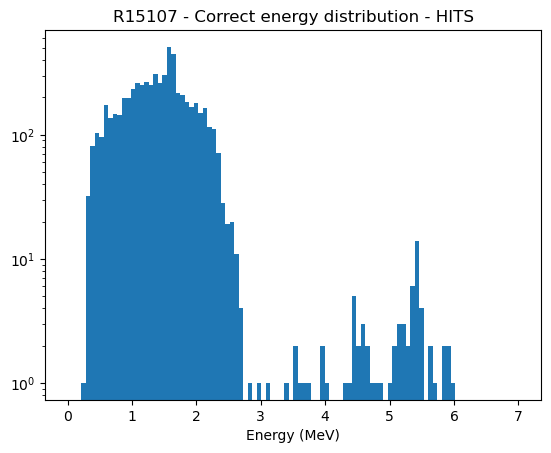

In [17]:

plt.hist(low_z_events.groupby('event').Ec.sum(), bins = 100, range = [0, 7])
plt.xlabel('Energy (MeV)')
plt.title(f'R{run} - Correct energy distribution - HITS')
plt.yscale('log')
plt.show()

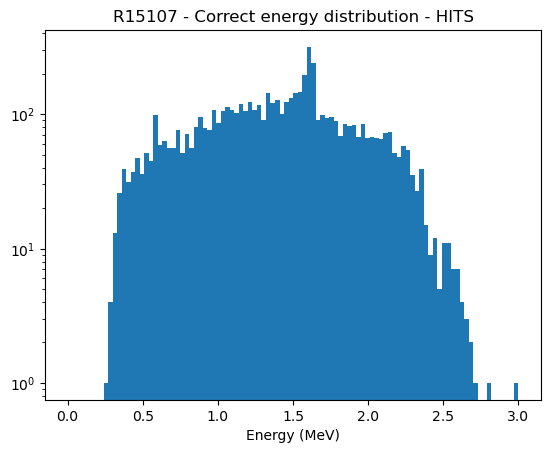

In [ ]:
plt.hist(low_z_events.groupby('event').Ec.sum(), bins = 150, range = [0, 3])
plt.xlabel('Energy (MeV)')
plt.title(f'R{run} - Correct energy distribution - HITS')
plt.yscale('log')
plt.show()

In [4]:
# and then beforehand
full_dst_pre_corr = pd.read_hdf('files/15107_merger_RECO.h5', key = 'RECO/Events')

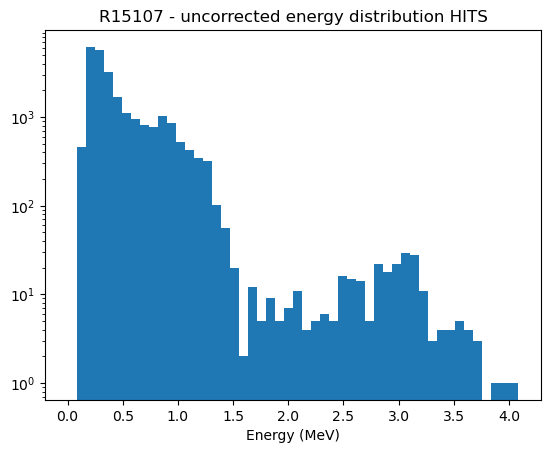

In [5]:
plt.hist(full_dst_pre_corr.groupby('event').Ec.sum(), bins = 50, range = [0, max(full_dst_pre_corr.groupby('event').Ec.sum())])
plt.xlabel('Energy (MeV)')
plt.title(f'R{run} - uncorrected energy distribution HITS')
plt.yscale('log')
plt.show()

# Extract tracks from differing energy regions for analysis

### Uncorrected energy
- **Photopeak** > 1.6 'MeV'

### Corrected energy
- **DES** 1.4-1.8 MeV 
- **Low E stuff (x-rays?)** 0-1 MeV
- **Post compton edge** > 2.4 MeV

In [42]:
def extract_df(df, e_lower, e_upper):
    '''
    param meaning Ec or E
    '''
    summed_e = df.groupby('event').Ec.sum()

    lower_e_list = summed_e[summed_e > e_lower]
    upper_e_list = lower_e_list[lower_e_list < e_upper]

    return df[df.event.isin(upper_e_list.keys())]

    

In [ ]:
# extract uncorrected energy above 1.6
high_E_uncor_df = extract_df(full_dst_pre_corr, 1.6, 100)
DES_Ec_df = extract_df(full_dst, 1.4, 1.8)
low_E_Ec_df = extract_df(full_dst, 0, 1)


In [72]:
post_CE_df = extract_df(full_dst, 2.2, 100)

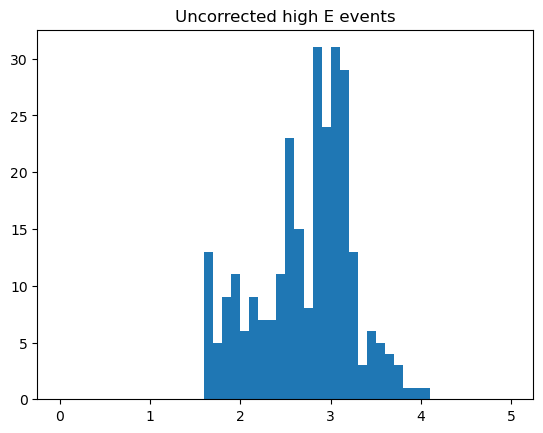

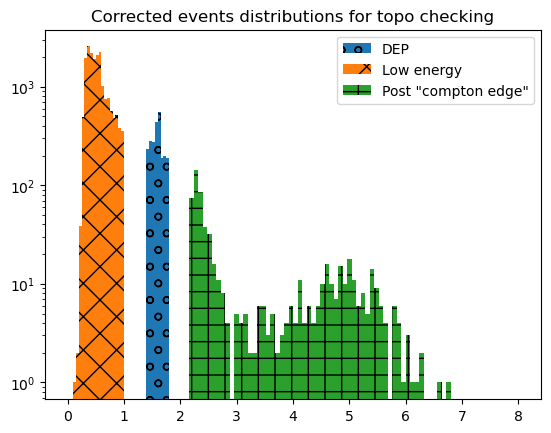

In [88]:
plt.hist(high_E_uncor_df.groupby('event').Ec.sum(), bins = 50, range = [0, 5])
plt.title('Uncorrected high E events')
plt.show()

plt.hist(DES_Ec_df.groupby('event').Ec.sum(), bins = 100, range = [0, 5], label = 'DEP', hatch = 'o')
plt.hist(low_E_Ec_df.groupby('event').Ec.sum(), bins = 100, range = [0, 5], label = 'Low energy', hatch = 'x')
plt.hist(post_CE_df.groupby('event').Ec.sum(), bins = 100, range = [0, 8], label = 'Post "compton edge"', hatch = '+')
plt.legend()
plt.yscale('log')
plt.title('Corrected events distributions for topo checking')
plt.show()

In [75]:
high_E_uncor_df.to_hdf('files/15107_energy_split/uncorr_gt1.6.h5', key = 'RECO/Events')
DES_Ec_df.to_hdf('files/15107_energy_split/corr_DES.h5', key = 'RECO/Events')
post_CE_df.to_hdf('files/15107_energy_split/corr_post_CE.h5', key = 'RECO/Events')
low_E_Ec_df.to_hdf('files/15107_energy_split/corr_low_E.h5', key = 'RECO/Events')

### where do the uncorrected energies sit in the energy range post-correction?

In [ ]:
uncor_evts = high_E_uncor_df.event.unique()

[ 795874  907384  648419  835137  411161 1106989 1333404 1269186 1536439
  151468 1344716  686702  436746  223834  961158  281241  643512 1165670
 1107913 1343106 1541248  267444  153904  488056  161149  491486  312342
  823615 1428345  750339 1111028   31250 1314567 1069245 1413394   47687
   97338   19008  800194  295228 1475645  234839  823553  713611 1168513
  371570 1157628 1012238 1245163 1397336 1453518 1253668  935371 1404637
  204711  777738 1409600  354112 1168289  226537 1211374  117113   59986
 1178166 1121984  242546  212544  985617 1467504  938777  578424  159551
  886354  750757  243901  696101  294616  387772 1309091   64183    6769
  755461  804853  569135 1344168  412930 1190224  486808  492135 1320641
    9849  436905  144389  477645  269472  703920  624428  415359  119861
 1249052  932841 1097404  458647 1033998  379148 1070559 1307887  577248
  857269  918498  700126 1282253   12390   79646 1197056   63133  771505
  850059  970431  420399 1207445 1282009  674416  7

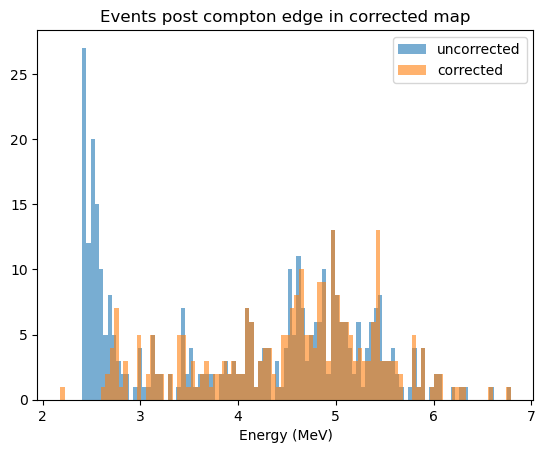

In [67]:
plt.hist(post_CE_df.groupby('event').Ec.sum(), bins = 100, label = 'uncorrected', alpha = 0.6)
plt.hist(full_dst[full_dst.event.isin(uncor_evts)].groupby('event').Ec.sum(), bins = 100, label = 'corrected', alpha = 0.6)
plt.title('Events post compton edge in corrected map')
plt.legend()
plt.xlabel('Energy (MeV)')
plt.show()